### IMPORT LIBRARIES

In [65]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

img_size = 100

In [66]:
class image_data:
    def __init__(self, id, ref_lat, ref_long, centroid_lat, centroid_long, num_of_cells, cells_lat, cells_long, cells_rssi): 

        self.id = id  # image id
        self.ref_lat = ref_lat  # reference latitude
        self.ref_long = ref_long  # reference longitude
        self.centroid_lat = centroid_lat  # centroid latitude
        self.centroid_long = centroid_long  # centroid longitude
        self.num_of_cells = num_of_cells  # number of recorded cells
        self.cells_lat = cells_lat  # list of latitude of cells
        self.cells_long = cells_long  # list of longitude of cells
        self.cells_rssi = cells_rssi  # list of rssi value of cells

        self.width = img_size  # image's width
        self.height = img_size  # image's height
        self.x = [] # x coordinate on image of cells
        self.y = [] # y coordinate on image of cells
        self.ref_x = self.width/2 - 1 # x coordinate on image of reference position
        self.ref_y = self.height/2 - 1 # y coordinate on image of reference position
        self.dmax = 0  # dmax as mentioned in the manuscript
        self.path_loss_exponent = []
        # Initialize the image
        self.img = np.ndarray((100,100))
        self.img[:] = -114
    

    # Get x, y coordinates on image of cells and reference position
    def update_xy(self):

        # Calculate dmax
        for lat in self.cells_lat:
            self.dmax = max(self.dmax, abs(self.centroid_lat - lat))
        for long in self.cells_long:
            self.dmax = max(self.dmax, abs(self.centroid_long - long))

        # Calculate x, y coordinates on image of cells, the formula can be found in the manuscript
        for i in range(self.num_of_cells):
            d_long = self.cells_long[i] - self.centroid_long
            d_lat = self.cells_lat[i] - self.centroid_lat

            x_coord = self.width/2 - 1
            y_coord = self.height/2 - 1

            if (self.dmax > 0):
                x_coord = max(0, int((d_long/(2 * self.dmax) + 0.5) * self.width) - 1)
                y_coord = max(0, int((d_lat/(2 * self.dmax) + 0.5) * self.width) - 1)
            self.x.append(x_coord)
            self.y.append(y_coord)

        # Calculate x, y coordinates on image of reference position
        if (self.dmax > 0):
            d_long = self.ref_long - self.centroid_long
            d_lat = self.ref_lat - self.centroid_lat
            self.ref_x = max(0, int((d_long/(2 * self.dmax) + 0.5) * self.width) - 1)
            self.ref_y = max(0, int((d_lat/(2 * self.dmax) + 0.5) * self.width) - 1)


    '''
        Calculate the spreading model of a cell base on: Its rssi, its position and reference position -> spreading loss coefficient

        The spreading model of mobile signal can be modeled by the log distance path loss model
        https://en.wikipedia.org/wiki/Log-distance_path_loss_model

        Simplified: 
        RSSI(d) = RSSI(d0) + coeff * log10(d0/d)
        In the function: d0 = 1, RSSI(1) = 0 (at source)
    '''
    def cell_spread_model(self, cell_id):

        rssi = self.cells_rssi[cell_id]  # The cell's rssi
        cell_x = self.x[cell_id]  # The cell's x coordinate on image
        cell_y = self.y[cell_id]  # The cell's y coordinate on image
        d = float(np.sqrt((self.ref_x - cell_x) ** 2 + (self.ref_y - cell_y) ** 2))  # Distance between the cell and the reference position

        if d == 0:
            self.img[cell_x][cell_y] = 0
            return
        
        exponent = -rssi/(np.log10(d))  # The spreading loss coefficient
        self.path_loss_exponent.append(exponent)

        for x in range (0, img_size):
            for y in range (0, img_size):
                if (x == cell_x and y == cell_y):
                    continue
                dis = float(np.sqrt((x - cell_x) ** 2 + (y - cell_y) ** 2))
                self.img[x][y] = max(self.img[x][y], -exponent *  np.log10(dis))
        self.img[cell_x][cell_y] = 0
        
        
    # Generate and return the image

    def gen_image(self) -> np.ndarray:
        self.update_xy()
        cnt = 2
        for cell_id in range(self.num_of_cells):
            self.cell_spread_model(cell_id)
            
        return self.img
    
    def print_info(self):
        print("Id: ", self.id)
        print("Reference latitude:", self.ref_lat)
        print("Reference longitude:", self.ref_long)
        print("Surrounding cells' data:")
        for cell in range (self.num_of_cells):
            print("_____________________")
            print("Info of cell number", cell)
            print("Cell's latitude:", self.cells_lat[cell])
            print("Cell's longitude:", self.cells_long[cell])
            print("Cell's RSSI value:", self.cells_rssi[cell])
            print("Calculated path loss exponent:", self.path_loss_exponent[cell])
            print("_____________________")

### READING INPUT DATA AND GENERATE IMAGE

In [67]:
file_path = "logFile_urban_data.csv"
data = pd.read_csv(file_path, header = None)

image_datas = []

for index, row in data.iterrows():
    id = row[0]
    ref_lat = row[1]
    ref_long = row[2]
    num_of_cells = int(row[4])
    cells_lat = []
    cells_long = []
    cells_rssi = []
    for i in range(num_of_cells):
        cells_lat.append(row[i * 5 + 7])
        cells_long.append(row[i * 5 + 8])
        cells_rssi.append(row[i * 5 + 9])
    
    centroid_lat = sum(cells_lat) / num_of_cells
    centroid_long = sum(cells_long) / num_of_cells
    image_datas.append(image_data(id, ref_lat, ref_long, centroid_lat, centroid_long, num_of_cells, cells_lat, cells_long, cells_rssi))




### SHOW IMAGE

Id:  2.0
Reference latitude: 20.95441002
Reference longitude: 105.76922249
Surrounding cells' data:
_____________________
Info of cell number 0
Cell's latitude: 20.956897
Cell's longitude: 105.768824
Cell's RSSI value: -71.0
Calculated path loss exponent: 57.391911152526305
_____________________
_____________________
Info of cell number 1
Cell's latitude: 20.950294
Cell's longitude: 105.778526
Cell's RSSI value: -77.0
Calculated path loss exponent: 42.07418978549838
_____________________
_____________________
Info of cell number 2
Cell's latitude: 20.95866
Cell's longitude: 105.765843
Cell's RSSI value: -83.0
Calculated path loss exponent: 53.49456029133382
_____________________
_____________________
Info of cell number 3
Cell's latitude: 20.950768
Cell's longitude: 105.767526
Cell's RSSI value: -69.0
Calculated path loss exponent: 48.536300320902875
_____________________
_____________________
Info of cell number 4
Cell's latitude: 20.954979
Cell's longitude: 105.774017
Cell's RSSI val

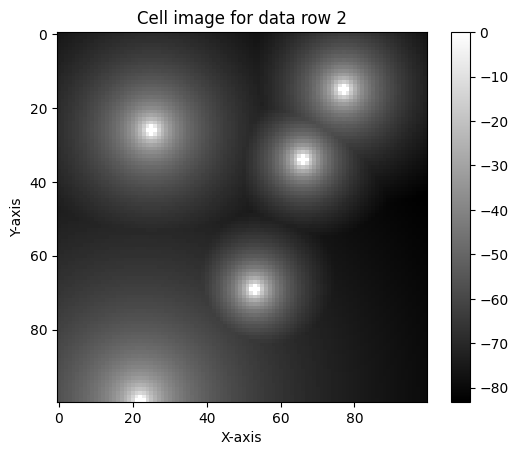

In [68]:
index = 2 # The index of the row in csv file

img = image_datas[index-1].gen_image() # Change the index to see the image corresponding to the data row in csv file
image_datas[index-1].print_info()
plt.imshow(img, cmap='gray', interpolation='none')
plt.colorbar()
plt.title(f"Cell image for data row {index}")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()